# Heatmap of Convolutional Layer in CNN-GRU model for Oomycete

In [1]:
# Load the libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from tensorflow.compat.v1.keras.models import load_model

In [2]:
import cv2
import glob

In [3]:
# Get the pretarined model and show the summary of the model
cnn_gru_oomycete = load_model("../../../data/secreted_data/saved_models/oomycete/cnn_gru/sequential_1.30-0.43.hdf5")
cnn_gru_oomycete.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 933, 16)           656       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 466, 16)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1200      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,873
Trainable params: 1,873
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Load datasets
dataset = np.load('../../../data/secreted_data/ready_to_process/encoded_files/oomycete/x_train_oomycete.npy')
dataset.shape

(102, 820, 20)

In [5]:
def get_sum_heatmap_from_files(data_name, class_eff, layer, verbose = True, dataset = dataset):
    npy_loading_pattern = "results_secreted/oomycete/all_matrices_" + class_eff + "_" + data_name + "_" + layer + "*.npy"
    data_loading_path = glob.glob(npy_loading_pattern)
    
    if verbose: print("Loading", data_name, "data from", len(data_loading_path) ,"files...")
    
    # Initalize empty matrix
    all_matrices = np.empty([0 , 1, np.load(data_loading_path[0]).shape[2]])

    # Append matrices from files
    for path in data_loading_path:
        data = np.load(path)
        all_matrices = np.concatenate((all_matrices, data))
        
    if verbose: print("Loaded", all_matrices.shape[0], "data samples")
    sum_all_matrices = np.sum(all_matrices, axis = 0)
    
    # Calculate heatmap
    heatmap = np.maximum(sum_all_matrices, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (dataset.shape[1], dataset.shape[2]))

    
    return(sum_all_matrices, heatmap)

In [6]:
def plot_heatmap(data, from_data, to_data, colorbar = None):
    plt.matshow(data[:,from_data:to_data], cmap = 'viridis', origin = "lower", vmin = 0, vmax = 1)
    ax = plt.gca()
    plot = ax.axes.get_yaxis().set_visible(False)
    if colorbar == "Yes":
        plt.colorbar()
    
    return plot

In [7]:
def plot_fft(data, threshold, length_to_plot):
    
    # reshape data
    data = data.reshape(data.shape[1])
    
    # transform real data to the frequency domain (Fourier transform)
    real_ft = np.fft.rfft(data)
    
    # remove undesired frequencies
    real_ft[threshold:] = 0 
    
    # move back to the time domain. (Inverse fourier transform)
    smooth_data = np.fft.irfft(real_ft)
    
    # plot the results
    plt.figure(figsize=[30, 12])
    plt.plot(data[:length_to_plot], label='Original')
    plt.plot(smooth_data[0:length_to_plot],'r', linewidth=3, label='Smooth')
    plt.legend(loc=0)
    plt.show()

In [8]:
# Define the function

def plot_bar(data, from_data = None, to_data = None):
    
    if from_data is not None and to_data is not None:
        data = data[:,from_data:to_data].ravel()
    else:
        data = data.ravel()
         
    plt.plot(data)
    fig = plt.gcf()
    fig.set_size_inches(30, 10)
    plt.xlabel('Position')
    plt.ylabel('Importance Score')

## Get all of the matrices from the the first convolutional layer

In [9]:
sum_all_matrices_xtrain_oomycete_cnn_gru, xtrain_oomycete_cnn_gru = get_sum_heatmap_from_files("x_train", "oomycete", "conv1d_1")

Loading x_train data from 1 files...
Loaded 102 data samples


In [10]:
sum_all_matrices_xval_oomycete_cnn_gru, xval_oomycete_cnn_gru = get_sum_heatmap_from_files("x_val", "oomycete", "conv1d_1")

Loading x_val data from 1 files...
Loaded 34 data samples


In [11]:
sum_all_matrices_xtest_oomycete_cnn_gru, xtest_oomycete_cnn_gru = get_sum_heatmap_from_files("x_test", "oomycete", "conv1d_1")

Loading x_test data from 1 files...
Loaded 34 data samples


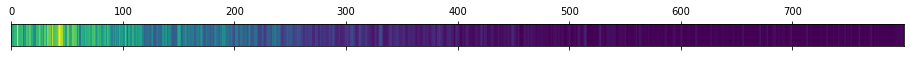

In [44]:
# Plot heatmap training
plot_heatmap(xtrain_oomycete_cnn_gru, xtrain_oomycete_cnn_gru.shape[0], xtrain_oomycete_cnn_gru.shape[1])

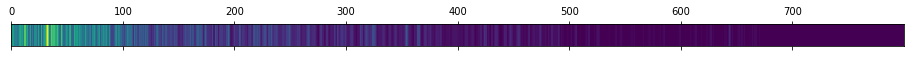

In [46]:
# Plot heatmap validation
plot_heatmap(xval_oomycete_cnn_gru, xval_oomycete_cnn_gru.shape[0], xval_oomycete_cnn_gru.shape[1])

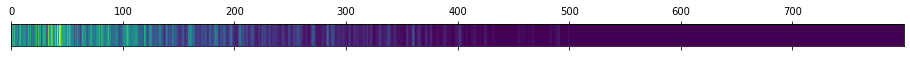

In [47]:
# Plot heatmap testing
plot_heatmap(xtest_oomycete_cnn_gru, xtest_oomycete_cnn_gru.shape[0], xtest_oomycete_cnn_gru.shape[1])

## Visualization

### Training data

In [12]:
rft_train = np.fft.rfft(xtrain_oomycete_cnn_gru[0])
rft_train[30:] = 0
y_smooth_train = np.fft.irfft(rft_train)

In [86]:
y_smooth_train.shape[0]

820

In [87]:
# Create dataframe for both data to plot together 
sum_df_train = pd.DataFrame(
    {
        "train" : xtrain_oomycete_cnn_gru[0].tolist(),
        "train_smooth": y_smooth_train.tolist()
    }
)

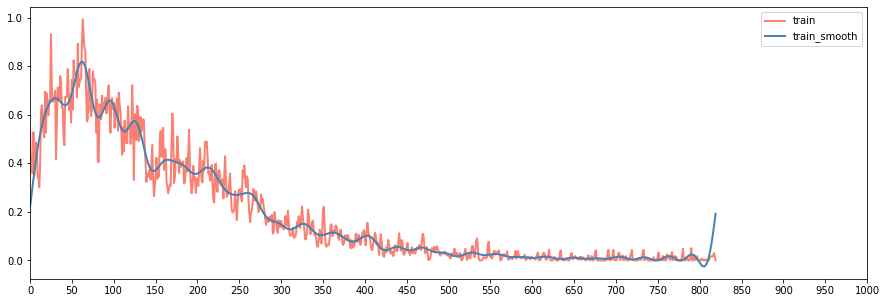

In [88]:
sum_df_train[0:850].plot.line(figsize=(15,5), color = ['salmon', 'steelblue'], linewidth = 2, xticks = np.linspace(0, 1000, num = 21))

### Validation data

In [13]:
rft_val = np.fft.rfft(xval_oomycete_cnn_gru[0])
rft_val[30:] = 0
y_smooth_val = np.fft.irfft(rft_val)

In [80]:
# Create dataframe for both data to plot together 
sum_df_val = pd.DataFrame(
    {
        "val" : xval_oomycete_cnn_gru[0][:y_smooth_val.shape[0]].tolist(),
        "val_smooth": y_smooth_val.tolist()
    }
)

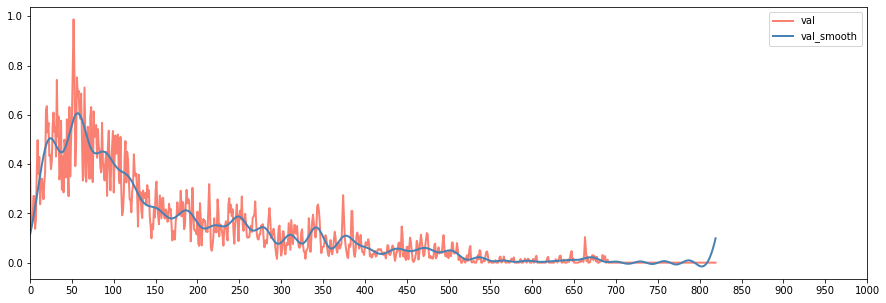

In [81]:
sum_df_val[0:850].plot.line(figsize=(15,5), color = ['salmon', 'steelblue'], linewidth = 2, xticks = np.linspace(0, 1000, num = 21))

### Testing data

In [14]:
rft_test = np.fft.rfft(xtest_oomycete_cnn_gru[0])
rft_test[30:] = 0
y_smooth_test = np.fft.irfft(rft_test)

In [83]:
# Create dataframe for both data to plot together 
sum_df_test = pd.DataFrame(
    {
        "test" : xtest_oomycete_cnn_gru[0][:y_smooth_test.shape[0]].tolist(),
        "test_smooth": y_smooth_test.tolist()
    }
)

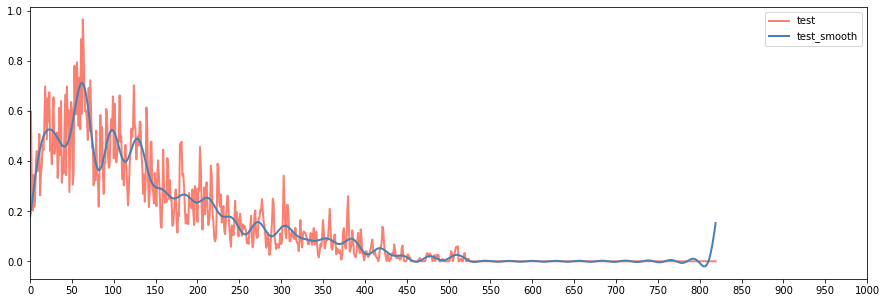

In [84]:
sum_df_test[0:850].plot.line(figsize=(15,5), color = ['salmon', 'steelblue'], linewidth = 2, xticks = np.linspace(0, 1000, num = 21))

### Plot all of the fft results together

In [15]:
from plotnine import *

In [16]:
df_fft_all_together = pd.DataFrame(
    {
        "index" : np.concatenate((
            np.arange(0, np.shape(y_smooth_train)[0], 1), 
            np.arange(0, np.shape(y_smooth_val)[0], 1), 
            np.arange(0, np.shape(y_smooth_test)[0], 1)
        )),
        "value" : np.concatenate((
            y_smooth_train.tolist(), 
            y_smooth_val.tolist(), 
            y_smooth_test.tolist()
        )),
        "dataset" : np.concatenate((
            np.repeat("train", np.shape(y_smooth_train)[0]), 
            np.repeat("val", np.shape(y_smooth_val)[0]), 
            np.repeat("test", np.shape(y_smooth_test)[0])
        )),
    }
)

In [17]:
df_fft_all_together

,index,value,dataset
0,0,0.220757,train
1,1,0.249543,train
2,2,0.278398,train
3,3,0.307022,train
4,4,0.335141,train
...,...,...,...
2455,815,0.063955,test
2456,816,0.083718,test
2457,817,0.105218,test
2458,818,0.128223,test


In [31]:
oomycete_all_datasets_plot = (
    ggplot(df_fft_all_together.query('index < 800')) +
    aes(x = 'index', y = 'value', color = 'dataset') +
    geom_line() +
    geom_vline(xintercept = 15, linetype = 'dashed') +
    geom_vline(xintercept = 40, linetype = 'dashed') +
    geom_vline(xintercept = 45, linetype = 'dashed', color = 'red') +
    geom_vline(xintercept = 70, linetype = 'dashed', color = 'red') +
    scale_color_cmap_d() +
    scale_x_continuous(breaks = np.arange(0, 800, 20)) +
    labs(x = 'Position') +
    theme_bw() +
    theme(figure_size = [15,4])
)

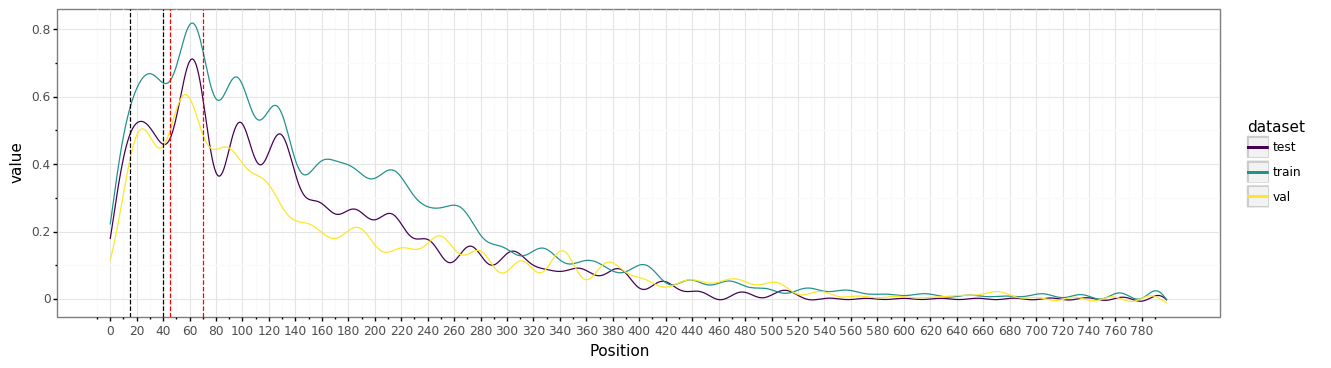

<ggplot: (7607339765)>

In [32]:
oomycete_all_datasets_plot

In [34]:
ggsave(plot = oomycete_all_datasets_plot, filename = "oomycete_all_datasets_plot.png", path = "fig")

/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 15 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: fig/oomycete_all_datasets_plot.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
